# Toy Batch SLAM Example

In this example, we'll consider a similar example to the one in the toy problems
notebook, but this time, we'll consider it in a batch estimation framework. To increase the complexity of the problem, we will also assume that the landmark
positions are unknown, and will be part of the state for estimation. Our goal
will be to estimate the robot's trajectory and the landmark positions using all
of the measurements collected. The state to estimate is given by 

$$
\mathcal{X} = \left(\mathbf{T}_{1}, \mathbf{T}_2, \ldots, \mathbf{T}_K,
\mathbf{p}_a^1, \mathbf{p}_a^2, \mathbf{p}_a^M \right),
$$

where similarly to in the previous example $\mathbf{T}_k \in SE(2)$ denotes the
pose of the robot at time $k$, written as 

$$ 
\mathbf{T}_k = \begin{bmatrix} \mathbf{C}_{ab_k}(\theta) & \mathbf{r}_a^k \\ \mathbf{0} & 1 \end{bmatrix} \in SE(2).
$$

Additionally, $\mathbf{p}_a^i \in \mathbb{R}^2$ denotes the position of the $i$'th landmark in
the inertial frame. Similarly to the previous example, the robot collects wheel
odometry measurements, which are used as the input to the process model given by


$$
\mathbf{T}_{k+1} = \mathbf{T}_k \exp(\boldsymbol{\varpi}_k^\wedge \Delta t)
$$

In this example, the robot will also collects direct measurements of the
landmark position, resolved in the body frame of the robot. The measurement
model is now a function of one robot pose and one landmark state, such that the
measurement of the $j$'th landmark at time $k$ is given by

$$
\begin{aligned}
\mathbf{y}_{jk} &= \mathbf{g}_{jk} \left(\mathbf{T}_k, \mathbf{p}_a^j \right) +
\mathbf{v}_{jk} \\
&= \mathbf{C}_{ab_k}^\mathsf{T} \left( \mathbf{p}_a^j - \mathbf{r}_a^k \right) + \mathbf{v}_{jk} \\
\end{aligned}
$$

where $\mathbf{v}_{jk} \sim \mathcal{N} \left( \mathbf{0}, \mathbf{R}_{jk}
\right)$ is white noise. Notice that unlike the previous example, each
measurement is a function of two states. To define the measurement model, the
[CompositeState](../_autosummary/navlie.composite.CompositeState.rst)
class can be leveraged. First, we'll start by defining some parameters that
we'll need for the rest of the example, and then we'll implement the measurement
model.

In [1]:
import navlie as nav
import numpy as np
import typing 
from pymlg import SO3

### Parameters used for the example
# if true, the information matrix in the batch problem will be inverted to compute the covariance
compute_covariance = True 
# If false, will run without noise, and all states initialized to groundtruth 
noise = True 
# String keys to identify the states
pose_key_str = "x"
landmark_key_str = "l"
# The end time of the simulation
t_end = 20.0

### Defining the measurement model
class PointRelativePositionSLAM(nav.types.MeasurementModel):
    def __init__(self, pose_state_id: typing.Any, landmark_state_id: typing.Any, R: np.ndarray):
        self.pose_state_id = pose_state_id
        self.landmark_state_id = landmark_state_id
        self._R = R

    def evaluate(self, x: nav.CompositeState):
        pose: nav.lib.SE2State = x.get_state_by_id(self.pose_state_id)
        landmark: nav.lib.VectorState = x.get_state_by_id(self.landmark_state_id)

        r_a = pose.position.reshape((-1, 1))
        p_a = landmark.value.reshape((-1, 1))
        C_ab = pose.attitude
        return C_ab.T @ (p_a - r_a)

    def jacobians(self, x: nav.CompositeState):
        pose: nav.lib.SE2State = x.get_state_by_id(self._pose_state_id)
        landmark: nav.lib.VectorState = x.get_state_by_id(self._landmark_state_id)

        r_zw_a = pose.position.reshape((-1, 1))
        C_ab = pose.attitude
        r_pw_a = landmark.value.reshape((-1, 1))
        y = C_ab.T @ (r_pw_a - r_zw_a)

        # Compute Jacobian of measurement model with respect to the state
        if pose.direction == "right":
            pose_jacobian = pose.jacobian_from_blocks(
                attitude=-SO3.odot(y), position=-np.identity(r_zw_a.shape[0])
            )
        elif pose.direction == "left":
            pose_jacobian = pose.jacobian_from_blocks(
                attitude=-C_ab.T @ SO3.odot(r_pw_a), position=-C_ab.T
            )

        # Compute jacobian of measurement model with respect to the landmark
        landmark_jacobian = pose.attitude.T

        # Build full Jacobian
        state_ids = [state.state_id for state in x.value]
        jac_dict = {}
        jac_dict[state_ids[0]] = pose_jacobian
        jac_dict[state_ids[1]] = landmark_jacobian
        return x.jacobian_from_blocks(jac_dict)

    def covariance(self, x: nav.CompositeState):
        return self._R

## Evaluating The Measurement Model

To evaluate this measurement model, we just need to create a CompositeState that
contains the robot state and the landmark state, as done below.

In [2]:
pose = nav.lib.SE2State(np.array([0.1, 1.0, 2.0]), state_id=pose_key_str)
landmark = nav.lib.VectorState(np.array([1.0, 2.0]), state_id=landmark_key_str)
R = np.identity(2) * 0.01

# Create the measurement model
model = PointRelativePositionSLAM(pose_key_str, landmark_key_str, R)

# Create a composite state
state = nav.lib.CompositeState([pose, landmark])
# Evaluate the model
y = model.evaluate(state)
print(y)

[[ 0.09642014]
 [-0.05653507]]


# Creating the simulated data
Next, we'll create the simulated data for this example. To use the data
generator included in navlie, it is convenient to define the same relative
position measurement model, but where the landmarks are included in the state
vector. We'll start by defining some landmarks and creating the relative
position measurement model with known landmarks. Then, we'll create the process
model using the BodyFrameVelocity process model defined in navlie.

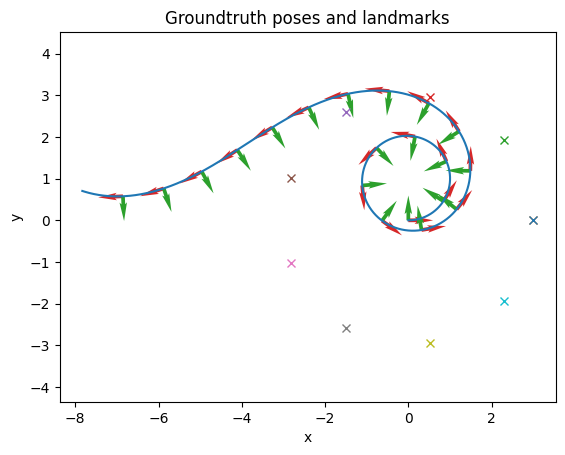

In [3]:
class PointRelativePosition(nav.types.MeasurementModel):
    def __init__(self, landmark_position: np.ndarray, landmark_id: int, R: np.ndarray):
        self.landmark_position = landmark_position.reshape((-1, 1))
        self.landmark_id = landmark_id
        self._R = R

    def evaluate(self, x: nav.lib.SE2State):
        r_a = x.position.reshape((-1, 1))
        p_a = self.landmark_position
        C_ab = x.attitude
        return C_ab.T @ (p_a - r_a)
    
    def covariance(self, x: nav.CompositeState):
        return self._R
    
# Now, create some landmarks arranged in a circle and create a list of
# measurement models, one for each landmark
landmark_positions = [np.array([3.0 * np.cos(theta), 3.0 * np.sin(theta)]) for theta in np.linspace(0, 2*np.pi, 10)]
landmarks = [nav.lib.VectorState(landmark, state_id=f"{landmark_key_str}{i}") for i, landmark in enumerate(landmark_positions)]
R = np.identity(2) * 0.1
meas_models = [PointRelativePosition(l.value, l.state_id, R) for l in landmarks]

# Create the process model
Q = np.identity(3) * 0.4
process_model = nav.lib.BodyFrameVelocity(Q)

# Input profile 
input_profile = lambda t, x: np.array(
    [np.cos(0.1 * t), 1.0, 0]
)

# Generate the data
x0 = nav.lib.SE2State(np.array([0, 0, 0]))
dg = nav.DataGenerator(
    process_model,
    input_profile,
    Q, 
    input_freq=100,
    meas_model_list=meas_models,
    meas_freq_list=[10] * len(meas_models),
)

gt_poses, input_list, meas_list = dg.generate(x0, start=0.0, stop=t_end, noise=noise)

# Plot the true state
import matplotlib.pyplot as plt
fig, ax = nav.plot_poses(gt_poses, step=100)
for landmark in landmarks:
    ax.plot(landmark.value[0], landmark.value[1], 'x')
ax.set_title("Groundtruth poses and landmarks")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Batch Estimation: From Weighted Nonlinear Least Squares to Unweighted Nonlinear Least Squares
Now, we wish to estimate the full state of the system using all of the inputs
and all of the measaurements. To do this, we want to define a nonlinear least
squares problem of the form 

$$
J (\mathcal{X}) = \frac{1}{2} \sum_{i=1}^N \mathbf{e}_i (\mathcal{X})^\mathsf{T} \mathbf{W}_i
\mathbf{e}_i (\mathcal{X}), 
$$

where $N$ is the number of error terms in the problem, and each $\mathbf{e}_i
(\mathcal{X})$ is an error term that is function
of the state. Additionally, $\mathbf{W}_i$ is a weight matrix, generally the inverse
covariance of the error. navlie has
a nonlinear least squares solver [Problem](../_autosummary/navlie.batch.problem.rst) that can be used to solve
general nonlinear least squares problems. However, the solver can only handle
*unweighted* nonlinear least squares problems of the form

$$
J (\mathcal{X}) = \frac{1}{2} \sum_{i=1}^N \mathbf{e}_i (\mathcal{X})^\mathsf{T} \mathbf{e}_i (\mathcal{X}).
$$

Thankfully, converting the weighted nonlinear least squares problem to an
equivalent unweighted problem is possible. Consider the Cholesky factorization
of $\mathbf{W}$, given by 

$$
\mathbf{W}_i = \mathbf{L}_i \mathbf{L}_i^\mathsf{T}.
$$

Defining $\tilde{\mathbf{e}_i} = \mathbf{L}_i \mathbf{e}_i$, we can rewrite the
original weighted cost function as 

$$
J (\mathcal{X}) = \frac{1}{2} \tilde{\mathbf{e}_i} (\mathcal{X})^\mathsf{T} \tilde{\mathbf{e}_i} (\mathcal{X}).
$$

Thus, for each error term in the problem, the user must pay careful attention to
weight the error by the square root of the inverse covariance matrix of that
particular error term.

Now that we've seen how to convert the original weighted nonlinear least squares
problem into a nonweighted one, let's explore how to define nonlinear least
squares problems in navlie.


# Defining Nonlinear Least Squares Problems in navlie
The `Problem` class in `navlie` is used to define and then solve nonlinear least
squares problems of the form 

$$
J (\mathcal{X}) = \frac{1}{2} \sum_{i=1}^N \mathbf{e}_i (\mathcal{X}_s)^\mathsf{T} \mathbf{e}_i
(\mathcal{X}_s).
$$

where each error term is a function of *a subset* of the full state, written
$\mathcal{X}_s$, where $\mathcal{X}_s \subset \mathcal{X}$. In `navlie` each
$\mathbf{e}_i$ is called a `Residual` (similarly to Ceres), and each state in
the problem is called a `Variable`. In many problems, residuals correspond to
one of three types: 

- A prior residual of the form
    $$
    \mathbf{e} \left(\mathcal{X}_k \right) = \mathcal{X}_k \ominus \tilde{\mathcal{X}}_k,
    $$
where $\tilde{\mathcal{X}}_k$ is a prior estimate of the state at time $k$.

- A process residual, defining an error using the process model for the
    state written 

    $$
    \mathbf{e} \left(\mathcal{X}_{k-1}, \mathcal{X}_k \right) = \mathcal{X}_k
    \ominus f \left(\mathcal{X}_{k-1}, \mathbf{u}_{k-1} \right), 
    $$ 
where $\ominus$ represents a general minus operator for the group, and $f
(\mathcal{X}_{k-1}, \mathbf{u}_{k-1})$ is the process model.

- A measurement residual of the form 

    $$ 
    \mathbf{e} \left(\mathcal{X}_s \right) = \mathbf{y} - \mathbf{g} \left(\mathcal{X}_s \right),
    $$
where $\mathbf{y}$ is a measurement, $\mathbf{g}$ is the measurement model, and $\mathcal{X}_s$ is the subset of the state that the measurement model is a
function of. Note that these are all *unweighted* forms of the residual.

To define a `Residual`, a user must inherit from the `Residual` base class
defined in [Residual](../_autosummary/navlie.batch.residuals.rst). Each
`Residual` The user must then implement the `evaluate()` method, which computes
the residual and the Jacobians of the residual with respect to each state that
the residual is a function of. The `Residual` class must also contain the unique
keys of each variable involved in the residual.

In the toy batch SLAM example, we will define a prior residual on the first
pose, process residuals that connect consecutive robot states through the
process model, and measurement residuals that connect the robot states to the
landmark states. The next section will show how these can be defined in navlie.

In [4]:
## Defining the residuals
from navlie.batch.residuals import Residual

# Define the prior residual, used to place a prior on the first state
class PriorResidual(Residual):
    
    def __init__(self, 
                 keys: typing.List[typing.Hashable],
                 prior_state: nav.lib.SE2State,
                 prior_covariance: np.ndarray):
        super().__init__(keys)
        self._cov = prior_covariance
        self._x0 = prior_state
        # Precompute squarae-root of the inverse covariance
        self._L = np.linalg.cholesky(np.linalg.inv(self._cov))

    def evaluate(self, 
                 states: typing.List[nav.types.State], 
                 compute_jacobians: typing.List[bool] = None):
        # Extract the SE2State from the list
        # The list should only be of length one since only one state is involved
        # in this residual
        x = states[0]
        error = x.minus(self._x0)
        # Weight the error by the square root of the information matrix
        error = self._L.T @ error

        # Compute Jacobian of error w.r.t x
        if compute_jacobians:
            # jacobians should be a list with length equal to the number of
            # states involved in this residual (in this case 1)
            jacobians = [None] 
            if compute_jacobians[0]:
                jacobians[0] = self._L.T @ x.minus_jacobian(self._x0)
            return error, jacobians

        return error

# Define the process residual, which links two consecutive robot states
class ProcessResidual(Residual):
    """
    A generic process residual.

    Can be used with any :class:`navlie.types.ProcessModel`.
    """

    def __init__(
        self,
        keys: typing.List[typing.Hashable],
        process_model: nav.lib.BodyFrameVelocity,
        u: nav.Input,
    ):
        super().__init__(keys)
        self._process_model = process_model
        self._u = u

    def evaluate(
        self,
        states: typing.List[nav.types.State],
        compute_jacobians: typing.List[bool] = None,
    ) -> typing.Tuple[np.ndarray, typing.List[np.ndarray]]:
        # Extract the states at times k-1 and k
        # The list should be of length 2, since there are two states
        # involved in this residual
        x_km1 = states[0]
        x_k = states[1]
        # Compute the timestamp from the states
        dt = x_k.stamp - x_km1.stamp

        # Evaluate the process model, compute the error
        x_k_hat = self._process_model.evaluate(x_km1.copy(), self._u, dt)

        # Compute the error, the difference between the state predicted from the 
        # process model and the actual state at time k
        e = x_k.minus(x_k_hat)

        # Scale the error by the square root of the info matrix
        L = self._process_model.sqrt_information(x_km1, self._u, dt)
        e = L.T @ e

        # Compute the Jacobians of the residual w.r.t x_km1 and x_k
        if compute_jacobians:
            # jac_list should be a list of length two, where the first element
            # is the jacobian of the residual w.r.t x_km1 and the second element
            # is the Jacobian of the residual w.r.t x_k
            jac_list = [None] * len(states)
            if compute_jacobians[0]:
                jac_list[0] = -L.T @ self._process_model.jacobian(
                    x_km1, self._u, dt
                )
            if compute_jacobians[1]:
                jac_list[1] = L.T @ x_k.minus_jacobian(x_k_hat)

            return e, jac_list

        return e
    
# Define the measurement residual, which links a robot state to a landmark
class PointRelativePositionResidual(Residual):
    def __init__(
        self,
        keys: typing.List[typing.Hashable],
        meas: nav.types.Measurement,
    ):
        super().__init__(keys)
        # Store the measurement, where the measurement contains the model
        self.meas = meas
        # Evaluate the square root information a single time since it does not
        # depend on the state in this case
        self.sqrt_information = self.meas.model.sqrt_information([])

    def evaluate(
        self,
        states: typing.List[nav.types.State],
        compute_jacobians: typing.List[bool] = None,
    ) -> typing.Tuple[np.ndarray, typing.List[np.ndarray]]:
        # In this case, states is a list of length two, where the first element
        # should be the robot state and the second element should be the
        # landmark state.
        
        # To evaluate the measurement model that we previously defined,
        # we need to create a composite state from the list of states
        eval_state = nav.CompositeState(states)
        
        # Evaluate the measurement model
        y_check = self.meas.model.evaluate(eval_state)
        # Compute the residual as the difference between the actual measurement
        error = self.meas.value - y_check

        L = self.sqrt_information
        error = L.T @ error

        if compute_jacobians:
            # Jacobians should be a list of length equal to the number of states
            jacobians = [None] * len(states)
            # The Jacobian of the residual is the negative of the measurement
            # model Jacobian
            full_jac = -self.meas.model.jacobian(eval_state)
            # The first 3 columns of the Jacobian are the Jacobian w.r.t the
            # robot state, and the last 2 columns are the Jacobian w.r.t the
            # landmark state
            if compute_jacobians[0]:
                jacobians[0] = L.T @ full_jac[:, :3]
            if compute_jacobians[1]:
                jacobians[1] = L.T @ full_jac[:, 3:]

            return error, jacobians
        return error

## Generating the Initial Estimate

Now that we've defined the residuals that will be used in the problem, we can
now create the problem, and add all of our variables and residuals to the
problem. We will first need an initial estimate for the states, where here, the
initial estimate for the robot trajectory is generated via dead-reckoning of the
noisy odometry measurements. The initial estimate for the landmarks in this
example will be generated by simply perturbing the groundtruth landmark
positions, but in practice, landmarks can be initialized by inverting the
measurement model.

Text(0, 0.5, 'y (m)')

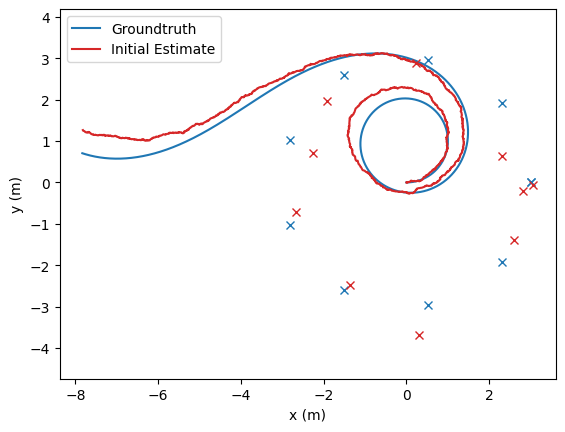

In [5]:
# Dead-reckon initial state forward using the noisy measurements
x0_hat = gt_poses[0].copy()
x0_hat.state_id = pose_key_str + "0"
init_pose_est = [x0_hat]
x = x0_hat.copy()
for k in range(len(input_list) -1):
    u = input_list[k]
    dt = input_list[k + 1].stamp - u.stamp 
    x = process_model.evaluate(x, u, dt)
    x.stamp = x.stamp + dt
    x.state_id = pose_key_str + str(k + 1)
    x.direction = "left"
    init_pose_est.append(x.copy())
 
# Generate estimates of landmarks by perturbing the groundtruth landmarks
init_landmark_est = []
for i, landmark in enumerate(landmarks):
    if noise:
        sigma_init = 0.4
    else: 
        sigma_init = 0.0
    perturbed_landmark = nav.lib.VectorState(landmark.value + np.random.randn(2) * sigma_init, state_id=landmark.state_id)
    init_landmark_est.append(perturbed_landmark)

# Plot the initial estimate compared to the groundtruth
fig, ax = nav.plot_poses(gt_poses, step=None, line_color='tab:blue', label="Groundtruth")
nav.plot_poses(init_pose_est, step=None, ax=ax, line_color='tab:red', label="Initial Estimate")

# Plot the true and the estimated landmarks
for landmark in landmarks:
    ax.plot(landmark.value[0], landmark.value[1], 'tab:blue', marker='x')
for landmark in init_landmark_est:
    ax.plot(landmark.value[0], landmark.value[1], 'tab:red', marker='x')

ax.legend()
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")

Now that we've generated our initial estimate, we can create the nonlinear least
squares problem and add our initial variable estimates to the problem. Each
variable that we'd like to optimize needs to have an associated key that is
unique to that variable - in this example, robot poses will have the keys `x0`,
`x1`, `x2`, etc., and landmarks will have the keys `l0`, `l1`, `l2`, etc.

In [6]:
from navlie.batch.problem import Problem

# Create a problem with default settings
problem = Problem()
# Add poses and landmarks to the problem
for i, state in enumerate(init_pose_est):
    problem.add_variable(state.state_id, state)
for i, landmark in enumerate(init_landmark_est):
    problem.add_variable(landmark.state_id, landmark)

# Now, lets print the keys of the variables that are in the problem!
init_keys_list = list(problem.variables_init.keys())
print("First 10 keys: ")
print(init_keys_list[1:10])
print("Last 10 keys:")
print(init_keys_list[-10:])

First 10 keys: 
['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']
Last 10 keys:
['l0', 'l1', 'l2', 'l3', 'l4', 'l5', 'l6', 'l7', 'l8', 'l9']


We can see that we've added all the poses to the problem, followed by all the landmarks.
Next, let's add in the error terms to the problem - one prior residual on the
first pose, process residuals connecting consecutive poses, and measurement
residuals connecting each pose and each landmark.

In [7]:
# Get the estimated pose timestamps (we'll need this for later)
est_stamps = [state.stamp for state in init_pose_est]

init_cov = np.identity(3) * 1e-7 # set a small covariance since we've initialized to groundtruth
x0_hat = init_pose_est[0].copy()
prior_residual = PriorResidual(x0_hat.state_id, x0_hat.copy(), init_cov)
problem.add_residual(prior_residual)

# Add process residuals
for k in range(len(input_list) - 1):
    u = input_list[k]

    key_1 = f"{pose_key_str}{k}"
    key_2 = f"{pose_key_str}{k+1}"
    process_residual = ProcessResidual(
        [key_1, key_2],
        process_model,
        u,
    )
    problem.add_residual(process_residual)

from navlie.utils import find_nearest_stamp_idx

# Before adding in the measurements to the problem, we need to replace the
# measurement model on the measurements with the measurement model with unknown
# landmark position
for k, meas in enumerate(meas_list):
    # Get the pose key 
    pose_idx = find_nearest_stamp_idx(est_stamps, meas.stamp)
    # Get state at this id
    pose = init_pose_est[pose_idx]
    landmark_state_id = meas.model.landmark_id
    meas.model = PointRelativePositionSLAM(pose.state_id, landmark_state_id, R)
    key_1 = pose.state_id
    key_2 = landmark_state_id
    meas_residual = PointRelativePositionResidual(
        [key_1, key_2],
        meas,
    )
    problem.add_residual(meas_residual) 


## Run Batch!

Now that all the variables and residuals have been added to the problem, we can
run our solver on the problem! Calling `problem.solve()` will return a
dictionary containing the optimized state and a summary of the optimization. The
problem will output the cost at each iteration, as well as the step sizes taken,
the change in cost `dC`, and the norm of the gradient.

In [8]:
# Solve the problem
opt_results = problem.solve()
variables_opt = opt_results["variables"]
print(opt_results["summary"])

Initial cost: 10209.908382510479
Iter: 0 || Cost: 2.1187e+03 || Step size: 1.8430e+01 || dC: 8.0913e+03 || dC/C: 3.8191e+00 || |grad|_inf: 2.5900e+02
Iter: 1 || Cost: 1.9963e+03 || Step size: 2.1161e+00 || dC: 1.2235e+02 || dC/C: 6.1290e-02 || |grad|_inf: 8.5779e+00
Iter: 2 || Cost: 1.9963e+03 || Step size: 5.0496e-02 || dC: 4.0240e-02 || dC/C: 2.0158e-05 || |grad|_inf: 3.1471e-01
Iter: 3 || Cost: 1.9963e+03 || Step size: 4.9900e-03 || dC: 1.9980e-04 || dC/C: 1.0009e-07 || |grad|_inf: 4.1650e-02
Iter: 4 || Cost: 1.9963e+03 || Step size: 2.6577e-04 || dC: 1.5637e-05 || dC/C: 7.8333e-09 || |grad|_inf: 2.0333e-03
Iter: 5 || Cost: 1.9963e+03 || Step size: 1.1292e-05 || dC: 3.4423e-07 || dC/C: 1.7244e-10 || |grad|_inf: 1.7811e-04
Iter: 6 || Cost: 1.9963e+03 || Step size: 1.7510e-06 || dC: 1.0526e-07 || dC/C: 5.2728e-11 || |grad|_inf: 1.3721e-05
Iter: 7 || Cost: 1.9963e+03 || Step size: 1.0217e-07 || dC: 6.7209e-09 || dC/C: 3.3668e-12 || |grad|_inf: 1.5173e-06
Iter: 8 || Cost: 1.9963e+03 || 

# Extracting the Estimates and the Covariances
To extract the covariance, we can use thee `problem.get_covariance_block()`
method, which will extract the *marginal covariance* of a particular variable
based on the state ID of that variable.
Note that this is useful for visualizing three sigma bounds and individual NEES
values for subsets of the state, but sometimes it is also useful to compute the
NEES for the entire trajectory. The problem class also outputs the full
information matrix of the problem, and the user can choose to manipulate this
themselves after the optimization has completed.

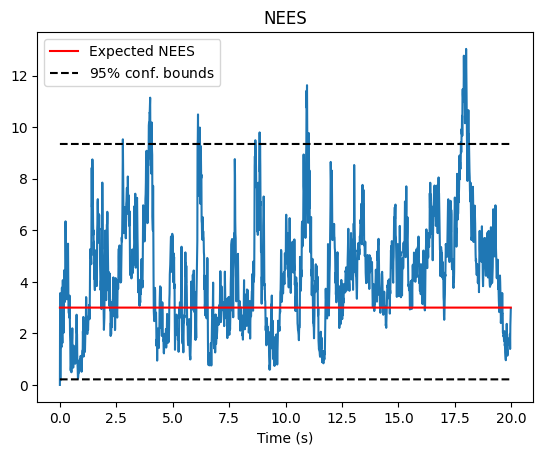

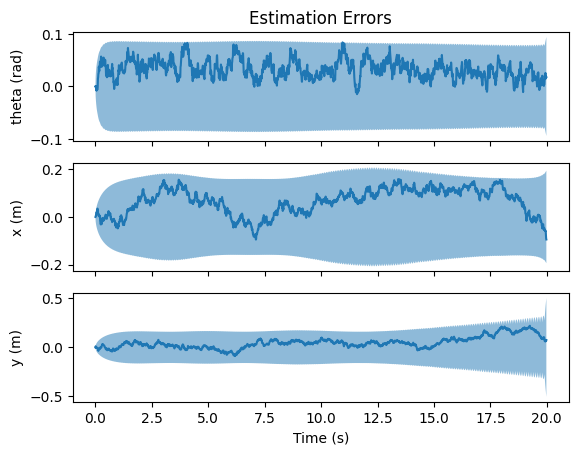

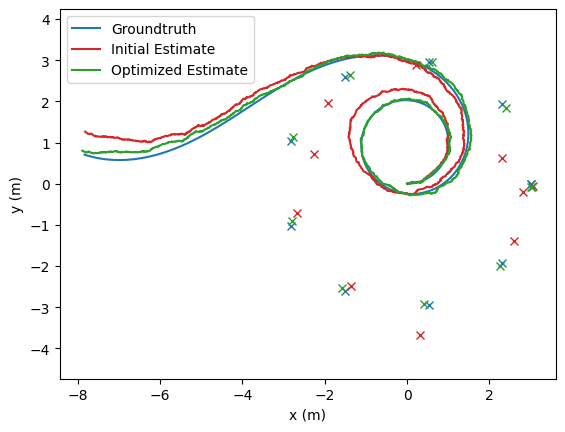

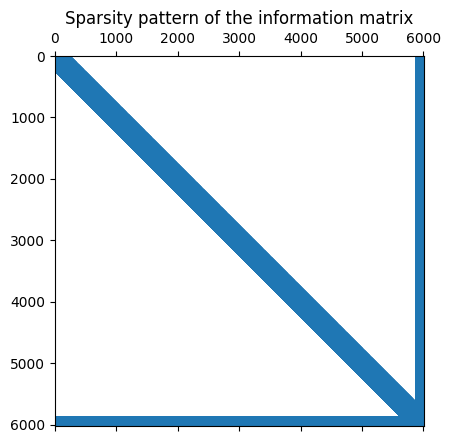

In [9]:
# Extract estimates
poses_results_list: typing.List[nav.types.StateWithCovariance] = []
for pose in init_pose_est:
    state = variables_opt[pose.state_id]
    if compute_covariance:
        # Extract the covariance for only this current pose state
        cov = problem.get_covariance_block(pose.state_id, pose.state_id)
    else:
        cov = np.identity(3)
    poses_results_list.append(nav.types.StateWithCovariance(state, cov))
    
landmarks_results_list: typing.List[nav.types.StateWithCovariance] = []
for landmark in init_landmark_est:
    state = variables_opt[landmark.state_id]
    if compute_covariance:
        cov = problem.get_covariance_block(landmark.state_id, landmark.state_id)
    else:
        cov = np.identity(2) 
    landmarks_results_list.append(nav.types.StateWithCovariance(state, cov))

# Postprocess the results and plot
gaussian_result_list = nav.GaussianResultList(
    [nav.GaussianResult(poses_results_list[i], gt_poses[i]) for i in range(len(poses_results_list))],
)

# Plot NEES 
fig, axs = nav.plot_nees(gaussian_result_list)
axs.set_xlabel("Time (s)")
axs.set_title("NEES")

fig, axs = nav.plot_error(gaussian_result_list)
axs[0].set_title("Estimation Errors")
axs[0].set_ylabel("theta (rad)")
axs[1].set_ylabel("x (m)")
axs[2].set_ylabel("y (m)")
axs[2].set_xlabel("Time (s)")
plt.show()

# Plot the initial estimate, optimized estimates, and groundtruth
opt_poses: typing.List[nav.lib.SE2State] = [state.state for state in poses_results_list]
fig, ax = nav.plot_poses(gt_poses, step = None, line_color='tab:blue', label="Groundtruth")
fig, ax = nav.plot_poses(init_pose_est, step=None, ax=ax, line_color='tab:red', label="Initial Estimate")
fig, ax = nav.plot_poses(opt_poses, step=None, ax=ax, line_color='tab:green', label="Optimized Estimate")

opt_landmarks: typing.List[nav.lib.VectorState] = [state.state for state in landmarks_results_list]
for landmark in landmarks:
    ax.plot(landmark.value[0], landmark.value[1], 'tab:blue', marker='x')
for landmark in init_landmark_est:
    ax.plot(landmark.value[0], landmark.value[1], 'tab:red', marker='x')
for landmark in opt_landmarks:
    ax.plot(landmark.value[0], landmark.value[1], 'tab:green', marker='x')
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.legend()

# Visualize the sparsity pattern of the information matrix
fig, ax = plt.subplots()
ax.set_title("Sparsity pattern of the information matrix")
ax.spy(opt_results["info_matrix"])
plt.show()
